<a href="https://colab.research.google.com/github/DKH707/B-ODE-DM/blob/main/WCEBS_Ensemble_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

From this amazing Github repo: https://github.com/stefanradev93/BayesFlow/tree/master/docs/source/tutorial_notebooks

In [ ]:
# ! pip install -q 'git+https://github.com/drscook/helpers'
! git clone https://github.com/stefanradev93/BayesFlow
git --reset 

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.6 MB/s eta 0:00:00
Cloning into 'BayesFlow'...
remote: Enumerating objects: 5104, done.
remote: Counting objects: 100% (336/336), done.
remote: Compressing objects: 100% (171/171), done.
remote: Total 5104 (delta 207), reused 286 (delta 165), pack-reused 4768
Receiving objects: 100% (5104/5104), 136.33 MiB | 28.70 MiB/s, done.
Resolving deltas: 100% (3087/3087), done.


In [ ]:
%reload_ext autotime
import os, sys
sys.path.append(os.path.abspath(os.path.join('../../..')))
sys.path.append('/content/BayesFlow')
import numpy as np
import pandas as pd
import datetime
from functools import partial
import tensorflow as tf
from bayesflow.simulation import GenerativeModel, Prior, Simulator
from bayesflow.networks import SequentialNetwork, InvertibleNetwork
from bayesflow.amortizers import AmortizedPosterior
from bayesflow.trainers import Trainer
import bayesflow.diagnostics as diag

/content/BayesFlow/bayesflow/trainers.py:26: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:
RNG = np.random.default_rng(2022)

## Defining the Generative Model

In [ ]:
def model_prior():
    """Generates random draws from the prior."""
    beta = RNG.uniform(0,0.01)
    alpha = RNG.uniform(0,1)
    eta = RNG.uniform(0,1)
    psi = RNG.uniform(0,0.5)
    return np.array([beta, alpha, eta, psi])

In [ ]:
prior = Prior(prior_fun=model_prior, param_names=[r'$\beta$', r'$\alpha$', r'$\eta$', r'$\psi$'])

In [ ]:
prior_means, prior_stds = prior.estimate_means_and_stds()

### Simulator (Implicit Likelihood Function)

In this section we define our observed data (but don't use it directly until after the training phase), our config for the trainer, and our system of ODEs.

In [ ]:
from scipy import interpolate

def load_data():
    obs_cases = np.array([2, 5, 10, 12, 14, 15, np.nan, 31, 42, 45, 53, 55, 58, np.nan, 52, 42, 40, 30, 23, 19, 13, 14, 11, 12, 9, 7, 5, 4, 2, 1, np.nan, 1])
    t = np.arange(len(obs_cases))
    mask = ~np.isnan(obs_cases)
    f = interpolate.interp1d(t[mask],obs_cases[mask])
    obs_filled = f(t)

    return obs_filled


In [ ]:
config = {
    # T is for time
    'T': 32,
    # N is for total population
    'N': 578,
    'obs_data': load_data()
}

In [ ]:
from scipy.integrate import odeint

#Initial conditions
R0 = 0
I0 = load_data()[0]
E0 = 0
S0 = config['N'] - I0 - E0 - R0

def stationary_SIR(params, N, T, eps=1e-5,Class=2):
    """Performs a forward simulation from the stationary SEIR model given a random draw from the prior,
    """
    # Extract parameters and round I0
    beta,alpha,eta,psi = params
     
    # Initial conditions
    S, E, I, R = [S0], [E0], [I0], [R0]
    
    # Reported new cases
    C = [I0]
    
    def diffSIR(y, t, p):
        ds = -p[0]*y[0]*y[2]
        de = p[0]*y[0]*y[2]-p[2]*y[1]
        di = p[2]*y[1]-p[1]*y[2]
        dr = p[1] * y[2]
        return [ds, de, di, dr]
    times = np.arange(1, T+1)
    y = odeint(diffSIR, t=times, y0=[*S,*E,*I,*R], args=((beta,alpha,eta, N),), rtol=1e-8)

    # Simulate T-1 timesteps
    for t in range(1, T):
       
        S.append(y[t,0])
        E.append(y[t,1])
        I.append(y[t,2])
        R.append(y[t,3])
        C.append(S[-2]-S[-1])
    
    S_obs = RNG.lognormal(mean=np.log(y[:,[0]]+eps), sigma=psi)
    E_obs = RNG.lognormal(mean=np.log(y[:,[1]]+eps),sigma=psi)
    I_obs = RNG.lognormal(mean=np.log(y[:,[2]]+eps), sigma=psi)
    R_obs = RNG.lognormal(mean=np.log(y[:,[3]]+eps), sigma=psi)

    if Class == 0:
        return S_obs
    elif Class == 1:
        return E_obs
    elif Class == 2: 
        return I_obs
    elif Class == 3: 
        return R_obs

### Loading Real Data

We will define a simple helper function to load the actually reported cases for the first 2 weeks in Germany.

In [ ]:
load_data()

array([ 2.,  5., 10., 12., 14., 15., 23., 31., 42., 45., 53., 55., 58.,
       55., 52., 42., 40., 30., 23., 19., 13., 14., 11., 12.,  9.,  7.,
        5.,  4.,  2.,  1.,  1.,  1.])

Since we won't vary the context variables during training, we can also define our simulator with fixed keyword arguments with the help of the `partial` function:

In [ ]:
simulator = Simulator(
    simulator_fun=partial(stationary_SIR, T=config['T'], N=config['N'])
)

Thus, whenever we call the `simulator` object, it will always use the keyword arguments provided to the `partial` function. Also, pay attention that we are passing the simulator function as a `simulator_fun` argument. A `Simulator` instance can also be initialized with a `batched_simulator_fun`, which implies that the simulator works on multiple (batched), instead of single, random draws from the prior.

### Generative Model

We now connect the prior and the simulator through the `GenerativeModel` wrapper:

In [ ]:
model = GenerativeModel(prior, simulator, name='Bayesian_ODE_simulator')

INFO:root:Performing 2 pilot runs with the Bayesian_ODE_simulator model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 4)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 32, 1)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


## Prior Checking

Any principled Bayesian workflow requires some prior predictive or prior pushforward checks to ensure that the prior specification is consistent with domain expertise (see https://betanalpha.github.io/assets/case_studies/principled_bayesian_workflow.html). The BayesFlow library provides some rudimentary visual tools for performing prior checking. For instance, we can visually inspect the joint prior in the form of bivariate plots:

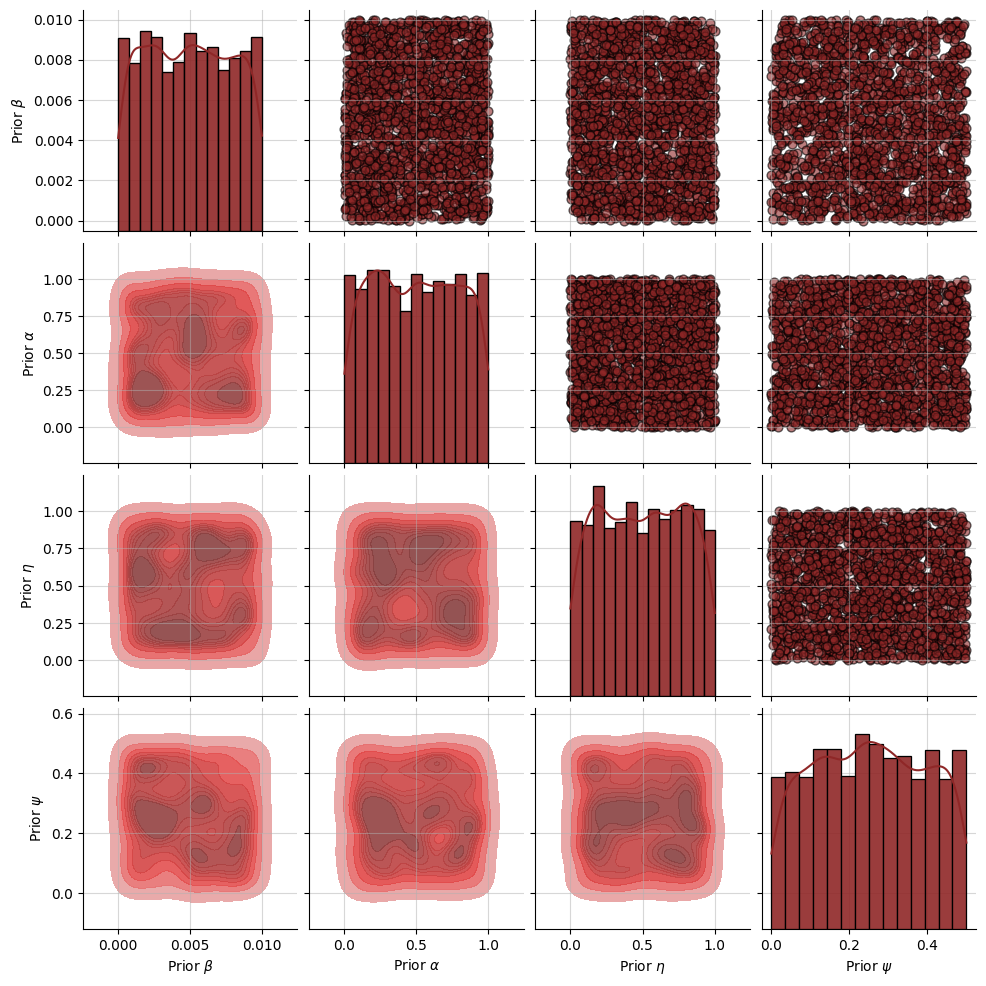

In [ ]:
# As per default, the plot_prior2d function will obtain 1000 draws from the joint prior.
f = prior.plot_prior2d()

## Defining the Neural Approximator

We can now proceed to define our BayesFlow neural architecture, that is, combine a summary network with an invertible inference network.

In [ ]:
summary_net = SequentialNetwork()

### Inference Network

In [ ]:
inference_net = InvertibleNetwork(num_params=len(prior.param_names), num_coupling_layers=3)

### Amortized Posterior

We can now connect the summary and inference networks via the `AmortizedPosterior` wrapper:

In [ ]:
amortizer = AmortizedPosterior(inference_net, summary_net, name='EBS_amortizer')

Note, that the `name` keyword argument is optional, but it is good practice to name your models and amortizers.

## Defining the Configurator

As a reminder, a configurator acts as an intermediary between a generative model and an amortizer:

<img src=https://github.com/drscook/BayesFlow/blob/master/docs/source/tutorial_notebooks/img/trainer_connection.png?raw=1 width=75%>

In other words, we need to ensure the outputs of the forward model are suitable for processing with neural networks. Currently, they are not, since our data $\boldsymbol{x}_{1:T}$ consists of large integer (count) values. However, neural networks like scaled data. Furthermore, our parameters $\boldsymbol{\theta}$ exhibit widely different scales due to their prior specification and role in the simulator, so we will standardize them using our previously computed prior means and standard deviations. In addition, ODE models are prone to divergences and exploding outputs, which will mess up our training. In sum, our configurator does the following:

1. Initializes a new dictionary (line 7).
2. Performs a log-transform on the simulated data and convert it to `float32` type (line 10).
3. Converts the prior draws to `float32` type and standardizes them (lines 13 - 14).
4. Removes potentially problematic simulations from the batch (lines 17 - 19).

In [ ]:
def configure_input(forward_dict):
    """ Function to configure the simulated quantities (i.e., simulator outputs)
    into a neural network-friendly (BayesFlow) format.
    """
    
    # Prepare placeholder dict
    out_dict = {}
    
    # Convert data to logscale 
    logdata = np.log1p(forward_dict['sim_data']).astype(np.float32)
    
    # Extract prior draws and z-standardize with previously computed means
    params = forward_dict['prior_draws'].astype(np.float32)
    params = (params - prior_means) / prior_stds
    
    # Remove a batch if it contains nan, inf or -inf
    idx_keep = np.all(np.isfinite(logdata), axis=(1, 2))
    if not np.all(idx_keep):
        print('Invalid value encountered...removing from batch')
    
    # Add to keys
    out_dict['summary_conditions'] = logdata[idx_keep]
    out_dict['parameters'] = params[idx_keep]
    
    return out_dict

In [ ]:
amortizer

## Defining the Trainer

Finally, we are in a position to define our `Trainer` instance. Notice that we also pass out custom `configurator` function to the constructer. The default configurator won't do in this case!

Note, that you should supply a `checkpoint_path` for the `Trainer` instance, if you don't want to save the neural approximators manually!

In [ ]:
# change var_obs
trainer = Trainer(amortizer=amortizer, 
                  generative_model=model, 
                  configurator=configure_input)

INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


Great, the trainer informs us that the consistency check (i.e., simulation -> configuration -> transformation -> loss computation) was successful. We can now train our networks on epidemiological simulations. We can also check out the number of trainable neural network parameters for the composite approximator:

In [ ]:
amortizer.summary()

Model: "EBS_amortizer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 invertible_network (Inverti  multiple                 221256    
 bleNetwork)                                                     
                                                                 
 sequential_network (Sequent  multiple                 91178     
 ialNetwork)                                                     
                                                                 
Total params: 312,434
Trainable params: 312,410
Non-trainable params: 24
_________________________________________________________________


## Training Phase

Ready to train! Since our simulator is pretty fast, we can safely go with online training. Let's glean the time taken for a batch of $32$ simulations:

In [ ]:
model(32);

We will train for $10$ epochs using $500$ iterations of $32$ simulations which amounts to a total of $10 \times 500 \times 32 = 160000$ simulations performed.

In [ ]:
h = trainer.train_online(epochs=10, iterations_per_epoch=500, batch_size=32, validation_sims=200)

INFO:root:Generated 200 simulations for validation.


Training epoch 1:   0%|          | 0/500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1, Loss: 2.031


Training epoch 2:   0%|          | 0/500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 2, Loss: 1.242


Training epoch 3:   0%|          | 0/500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 3, Loss: 0.821


Training epoch 4:   0%|          | 0/500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 4, Loss: 0.387


Training epoch 5:   0%|          | 0/500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 5, Loss: 0.387


Training epoch 6:   0%|          | 0/500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 6, Loss: 0.030


Training epoch 7:   0%|          | 0/500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 7, Loss: 0.151


Training epoch 8:   0%|          | 0/500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 8, Loss: -0.210


Training epoch 9:   0%|          | 0/500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 9, Loss: -0.255


Training epoch 10:   0%|          | 0/500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 10, Loss: -0.294


### Inspecting the Loss

Following our online simulation-based training, we can quickly visualize the loss trajectory using the `plot_losses` function from the `diagnostics` module.

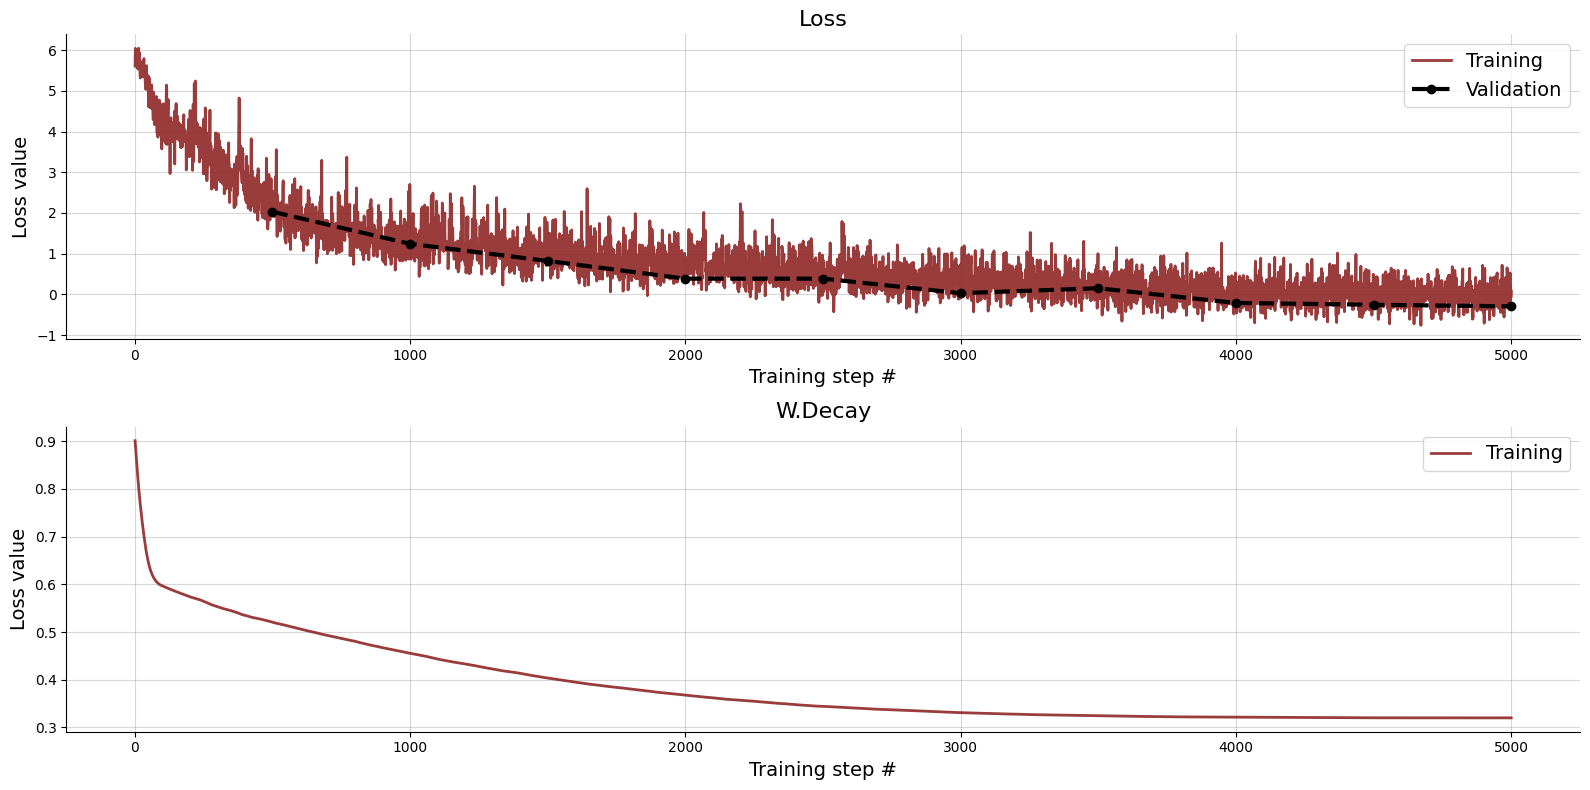

In [ ]:
f = diag.plot_losses(h['train_losses'], h['val_losses'])

Great, it seems that our approximator has converged! Before we get too excited and throw our networks at real data, we need to make sure that they meet our expectations <em>in silico</em>, that is, given the small world of simulations the networks have seen.

## Validation Phase

### Inspecting the Latent Space

A quick and useful diagnostic is to check whether the marginal latent distribution $p(\boldsymbol{z})$ has the prescribed probabilistic structure. Since, by default, we optimize the amortizer with the Kullback-Leibler (KL) loss (also known as maximum likelihood training, which is not to be confused with maximum likelihood estimation!), we expect to observe approximately Gaussian latent space with independent axes. Moreover, since the trainer also keeps an internal `SimulationMemory` instance, we can also directly call it's `diagnose_latent2d` method (also available in the `diagnostics` module):

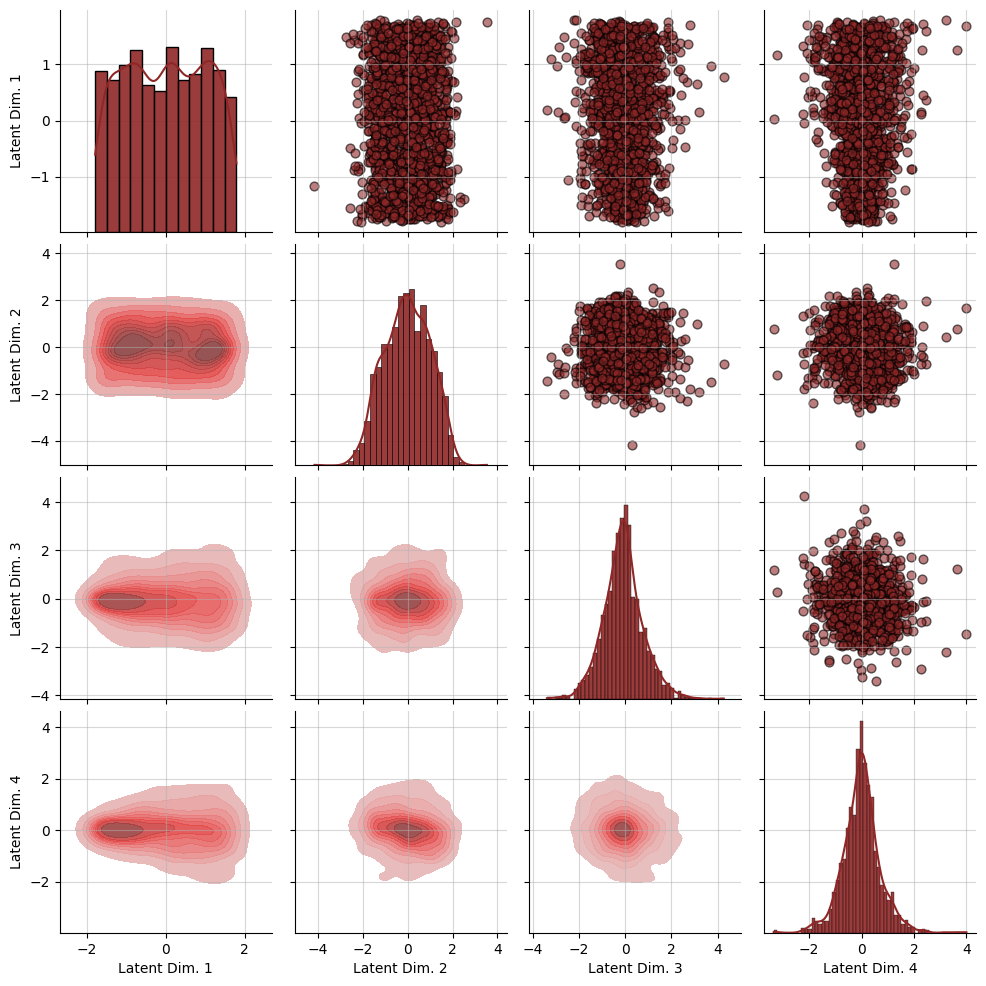

In [ ]:
f = trainer.diagnose_latent2d()

### Simulation-Based Calibration - Rank Histograms

As a further <strong>small world</strong> (i.e., before real data) sanity check, we can also test the calibration of the amortizer through simulation-based calibration (SBC). See the corresponding paper by Sean Talts, Michael Betancourt, Daniel Simpson, Aki Vehtari, and Andrew Gelman for more details:

https://arxiv.org/pdf/1804.06788.pdf

Accordingly, we expect to observe approximately uniform rank statistic histograms.

### Simulation-Based Calibration - Rank ECDF

For models with many parameters, inspecting many histograms can become unwieldly. Moreover, the `num_bins` hyperparameter for the construction of SBC rank histograms can be hard to choose. An alternative diagnostic approach for calibration is through empirical cumulative distribution functions (ECDF) of rank statistics. You can read more about this approach in the corresponding paper by Teemu Säilynoja, Paul-Christian Bürkner, and Aki Vehtari:

https://arxiv.org/abs/2103.10522

In order to inspect the ECDFs of marginal distributions, we will simulate $300$ new pairs of simulated data and generating parameters $(\boldsymbol{x}, \boldsymbol{\theta})$ and use the function `plot_sbc_ecdf` from the `diagnostics` module: 

In [ ]:
# Generate some validation data
validation_sims = trainer.configurator(model(batch_size=300))

# Generate posterior draws for all simulations
post_samples = amortizer.sample(validation_sims, n_samples=100)

We can also produce stacked ECDFs and compute ECDF differences for a more dynamic visualization range.

Fianlly, we can also compute SBC histograms on the new validation data by calling the function `plot_sbc_histograms` directly.

### Inferential Adequacy (Global)

Depending on the application, it might be interesting to see how well summaries of the full posterior (e.g., means, medians) recover the assumed true parameter values. We can test this <em>in silico</em> via the `plot_recovery` function in the `diagnostics` module. For instance, we can compare how well posterior means recover the true parameter (i.e., posterior z-score, https://betanalpha.github.io/assets/case_studies/principled_bayesian_workflow.html). Below, we re-use the $300$ simulations we took for computing the rank ECDFs, but obtain a larger number of posterior draws per data set for more stable results:

In [ ]:
post_samples = amortizer.sample(validation_sims, n_samples=500)

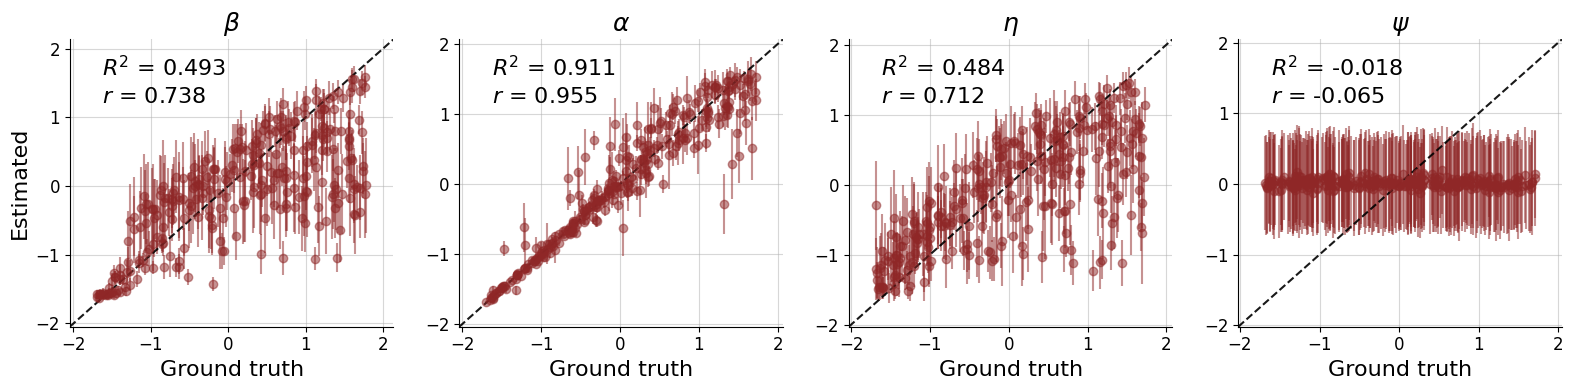

In [ ]:
f = diag.plot_recovery(post_samples, validation_sims['parameters'], param_names=prior.param_names)

## Inference Phase

We can now move on to using real data. As an important general remark: remember that the real and simulated data need to be in the same format (i.e., discrete indicators should be one-hot-encoded, transformations during training should also be applied during inference, etc.).

### Bivariate Posteriors

Finally, we can feed the real case data from the first two weeks and inspect the approximate posteriors or obtain model-based predictions.

In [ ]:
# Format data into a 3D array of shape (1, n_time_steps, 1) and perform log transform
obs_data = np.log1p(config['obs_data'])[np.newaxis, :, np.newaxis].astype(np.float32)

In [ ]:
# Obtain 500 posterior draws given real data
post_samples = amortizer.sample({'summary_conditions': obs_data}, 500)

# Undo standardization to get parameters on their original (unstandardized) scales
post_samples = prior_means + post_samples * prior_stds

#### Standalone

Using the `plot_posterior_2d` function from the `diagnostics` module, we can look at the bivariate posteriors in isolation:

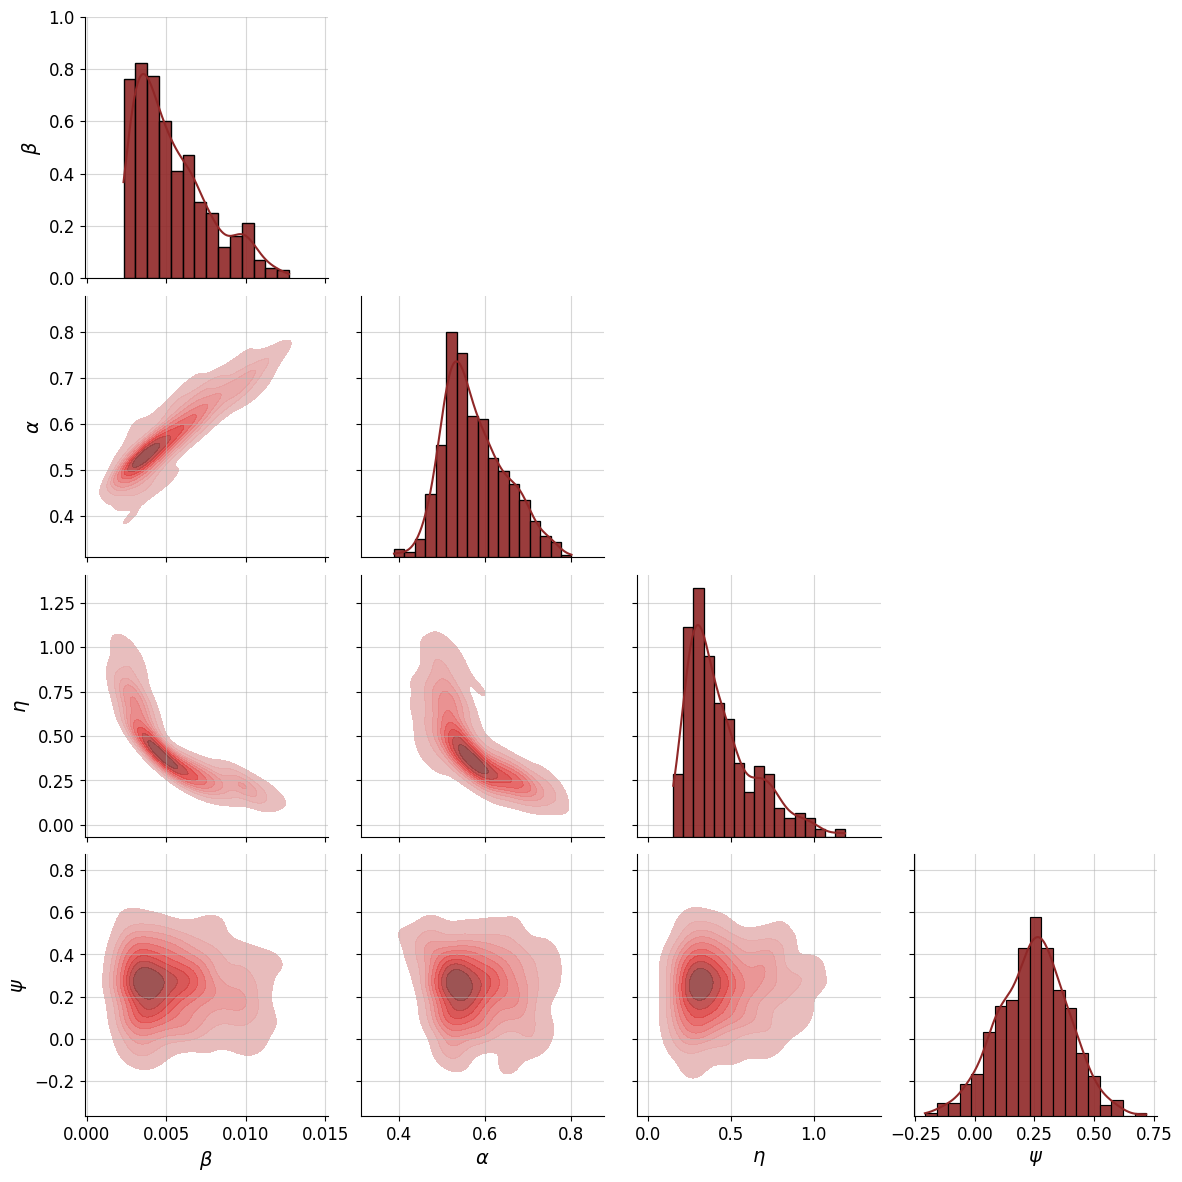

In [ ]:
f = diag.plot_posterior_2d(post_samples, param_names=prior.param_names)

#### Compared to Prior

In addition, we can have a more informative plot which indicates the Bayesian surprise (i.e., difference between prior and posterior) by also supplying the prior object to the function:

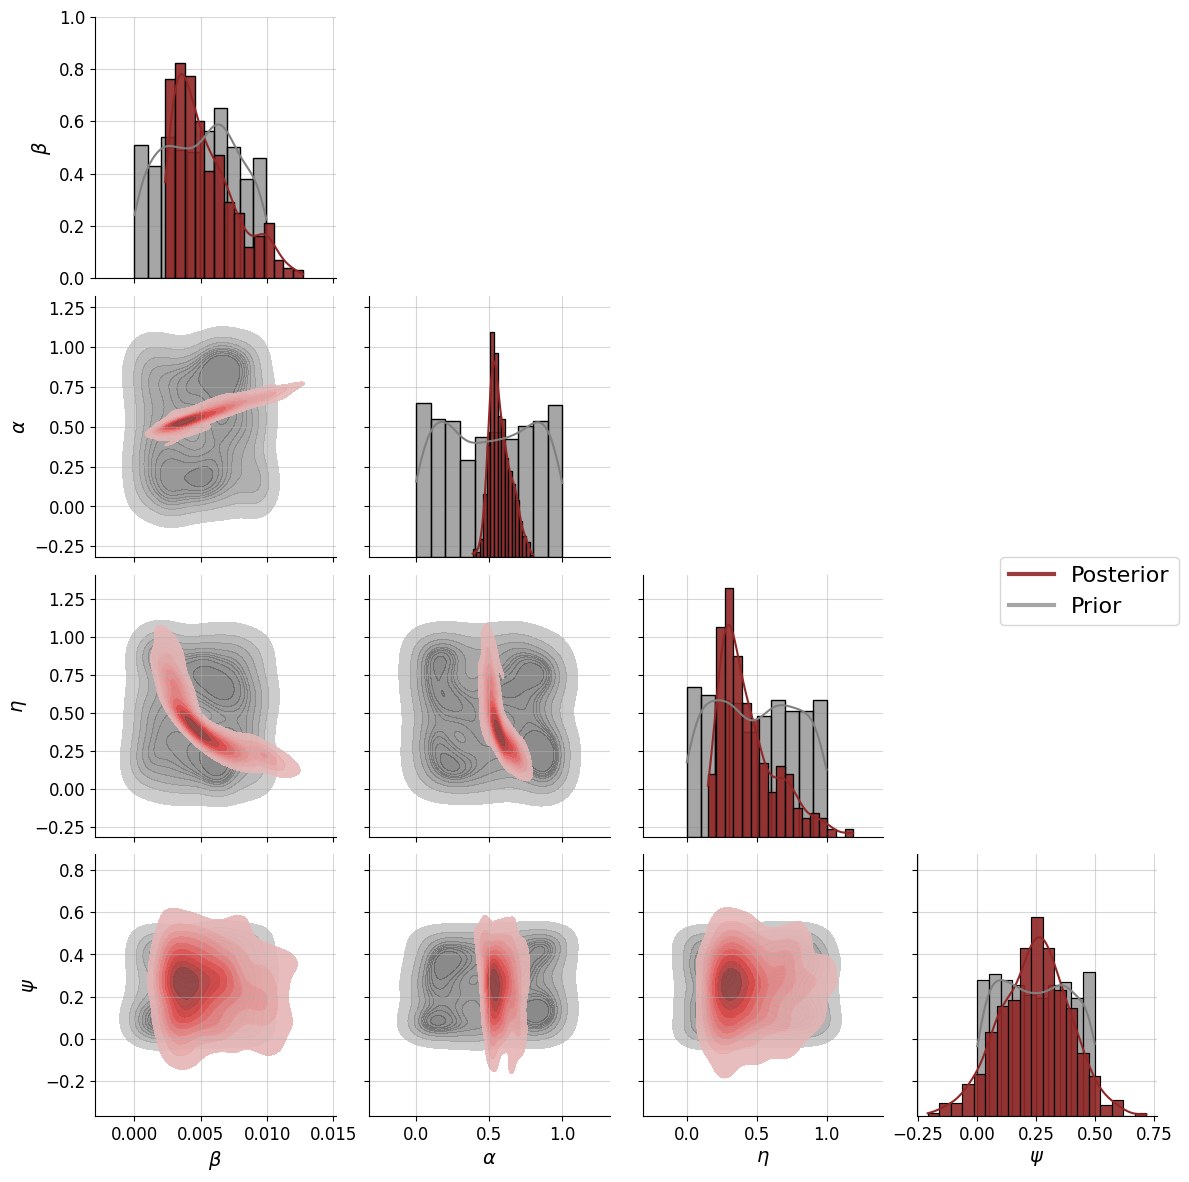

In [ ]:
f = diag.plot_posterior_2d(post_samples, prior=prior)

In [ ]:
post_samples

array([[0.00510834, 0.51859098, 0.34746324, 0.43830849],
       [0.01271283, 0.76655089, 0.1504701 , 0.07064049],
       [0.00334695, 0.51286004, 0.57786818, 0.04802665],
       ...,
       [0.00310193, 0.60277846, 0.69209251, 0.51908754],
       [0.01174939, 0.75664539, 0.17232494, 0.38999549],
       [0.00654533, 0.59184494, 0.28563005, 0.23163452]])

### Posterior Retrodictive Checks

These are also called <em>posterior predictive checks</em>, but here we want to explicitly highlight the fact that we are not predicting future data but testing the <strong>generative performance</strong> or <strong>re-simulation performance</strong> of the model. In other words, we want to test how well the simulator can reproduce the actually observed data given the parameter posterior $p(\boldsymbol{\theta} | \boldsymbol{x}_{1:T})$. 

Here, we will create a custom function which plots the observed data and then overlays draws from the posterior predictive.

In [ ]:
import matplotlib.pyplot as plt

def plot_ppc(config, post_samples, logscale=True, color='Blue', 
                            dummy=True, figsize=(12, 6), font_size=18):
    """
    Helper function to perform some plotting of the posterior predictive.
    """
    # Plot settings
    plt.rcParams['font.size'] = font_size
    
    # Remove parameters < 0
    samples = post_samples[np.sum(post_samples < 0, axis=1) == 0]
    
    f, ax = plt.subplots(1, 1, figsize=(12,12))
    j=0
    all=[]
    # Re-simulations
    sims_S = []
    for i in range(samples.shape[0]):  
        # Note - simulator returns 2D arrays of shape (T, 1), so we remove trailing dim 
        sim_S_cases = stationary_SIR(samples[i], config['N'], config['T'], Class=0)[:, 0]
        sims_S.append(sim_S_cases)
    sims_S = np.array(sims_S)

    sims=[]
    for i in range(samples.shape[0]):  
        # Note - simulator returns 2D arrays of shape (T, 1), so we remove trailing dim 
        sim_cases = stationary_SIR(samples[i], config['N'], config['T'])[:, 0]
        sims.append(sim_cases)
    sims = np.array(sims)

    sims_R = []
    for i in range(samples.shape[0]):  
        # Note - simulator returns 2D arrays of shape (T, 1), so we remove trailing dim 
        sim_R_cases = stationary_SIR(samples[i], config['N'], config['T'],Class=3)[:, 0]
        sims_R.append(sim_R_cases)
    sims_R = np.array(sims_R)

    sims_E = []
    for i in range(samples.shape[0]):  
        # Note - simulator returns 2D arrays of shape (T, 1), so we remove trailing dim 
        sim_E_cases = stationary_SIR(samples[i], config['N'], config['T'],Class=1)[:, 0]
        sims_E.append(sim_E_cases)
    sims_E = np.array(sims_E)
    
    # Compute quantiles for each t = 1,...,T
    # qs_50 = np.quantile(sims_S, q=[0.25, 0.75], axis=0)
    # qs_90 = np.quantile(sims_S, q=[0.05, 0.95], axis=0)
    # qs_95 = np.quantile(sims_S, q=[0.025, 0.975], axis=0)

    qi_50 = np.quantile(sims, q=[0.25, 0.75], axis=0)
    qi_90 = np.quantile(sims, q=[0.05, 0.95], axis=0)
    qi_95 = np.quantile(sims, q=[0.025, 0.975], axis=0)

    # qr_50 = np.quantile(sims_R, q=[0.25, 0.75], axis=0)
    # qr_90 = np.quantile(sims_R, q=[0.05, 0.95], axis=0)
    # qr_95 = np.quantile(sims_R, q=[0.025, 0.975], axis=0)

    # qe_50 = np.quantile(sims_E, q=[0.25, 0.75], axis=0)
    # qe_90 = np.quantile(sims_E, q=[0.05, 0.95], axis=0)
    # qe_95 = np.quantile(sims_E, q=[0.025, 0.975], axis=0)
    
    # Plot median predictions and observed data
    ax.plot(np.median(sims, axis=0), label='Median predicted Infected', color='red')
    ax.plot(config['obs_data'], marker='o', label='Reported cases', color='black', linestyle='dashed', alpha=0.8)
    # ax.plot(np.median(sims_S, axis=0), label='Median predicted Susceptible', color='blue')
    # ax.plot(np.median(sims_R, axis=0), label='Median predicted Recovered', color='green')
    # ax.plot(np.median(sims_E, axis=0), label='Median predicted Exposed', color='purple')
    
    # Add compatibility intervals (also called credible intervals)
    # ax.fill_between(range(config['T']), qs_50[0], qs_50[1], color='blue', alpha=0.3)
    # ax.fill_between(range(config['T']), qs_90[0], qs_90[1], color='blue', alpha=0.2)
    # ax.fill_between(range(config['T']), qs_95[0], qs_95[1], color='blue', alpha=0.1)

    ax.fill_between(range(config['T']), qi_50[0], qi_50[1], color='red', alpha=0.3)
    ax.fill_between(range(config['T']), qi_90[0], qi_90[1], color='red', alpha=0.2)
    ax.fill_between(range(config['T']), qi_95[0], qi_95[1], color='red', alpha=0.1)

    # ax.fill_between(range(config['T']), qr_50[0], qr_50[1], color='green', alpha=0.3)
    # ax.fill_between(range(config['T']), qr_90[0], qr_90[1], color='green', alpha=0.2)
    # ax.fill_between(range(config['T']), qr_95[0], qr_95[1], color='green', alpha=0.1)

    # ax.fill_between(range(config['T']), qe_50[0], qe_50[1], color='purple', alpha=0.3)
    # ax.fill_between(range(config['T']), qe_90[0], qe_90[1], color='purple', alpha=0.2)
    # ax.fill_between(range(config['T']), qe_95[0], qe_95[1], color='purple', alpha=0.1)
    
    # Grid and schmuck
    ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel('Days since initial datapoint')
    ax.set_ylabel('Number of cases')
    ax.minorticks_off()
    if not logscale:
        ax.set_yscale('log')
    ax.legend(fontsize=font_size)
   # print(sims,sims_R,sims_S)
    return f

We can now go on and plot the re-simulations:

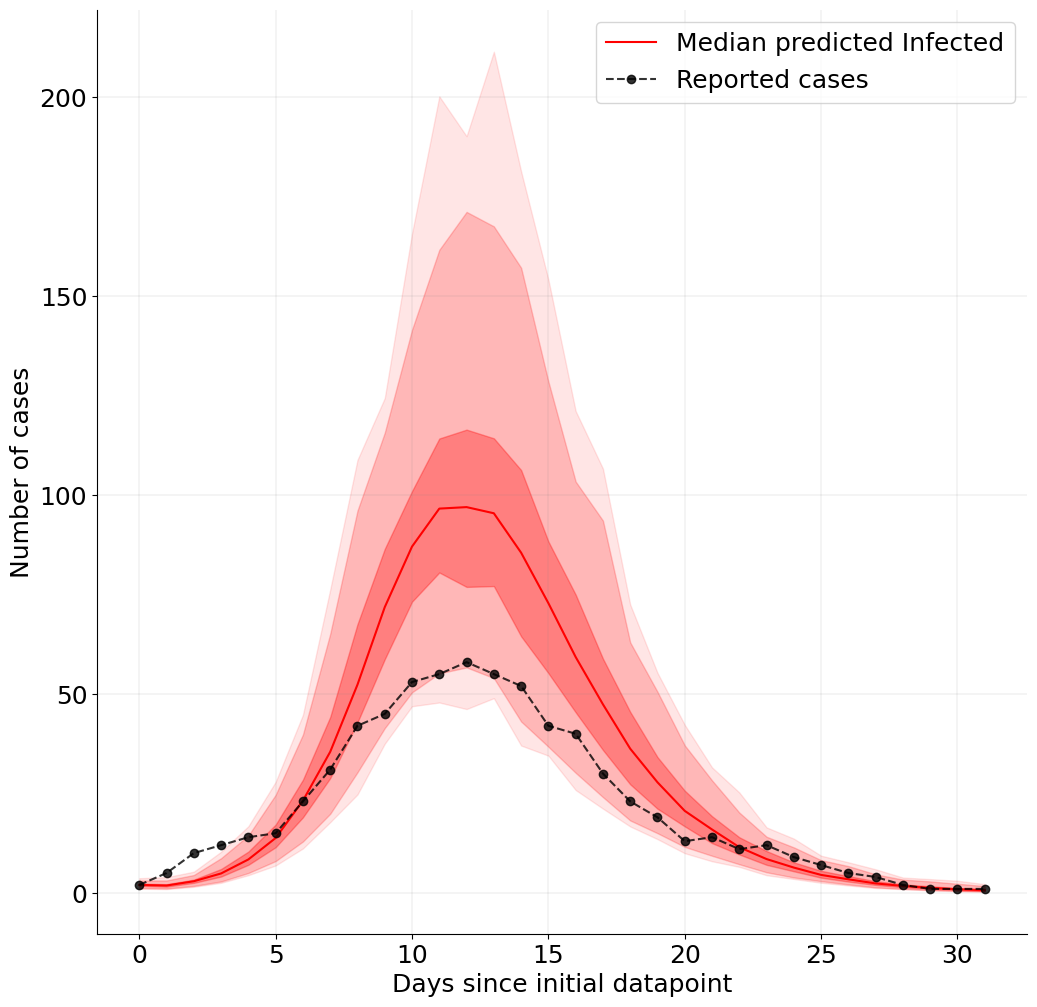

In [ ]:
f = plot_ppc(config, post_samples)

# **"Today's Posterior is Tomorrow's Prior." - T. Faulkenberry**

In [ ]:
post_samples

array([[0.00510834, 0.51859098, 0.34746324, 0.43830849],
       [0.01271283, 0.76655089, 0.1504701 , 0.07064049],
       [0.00334695, 0.51286004, 0.57786818, 0.04802665],
       ...,
       [0.00310193, 0.60277846, 0.69209251, 0.51908754],
       [0.01174939, 0.75664539, 0.17232494, 0.38999549],
       [0.00654533, 0.59184494, 0.28563005, 0.23163452]])

In [ ]:
# Calculate new priors
def calcNextPriors():
  # Beta
  beta_mean = np.mean(post_samples[:,0])
  beta_median = np.median(post_samples[:,0])

  beta_mu = np.log(beta_median)
  beta_sigma = np.sqrt(np.abs((2*(np.log(beta_mean) - np.log(beta_median)))))

  print ("New beta params =", beta_mu, beta_sigma)
  #------

  # Alpha
  alpha_mean = np.mean(post_samples[:,1])
  alpha_median = np.median(post_samples[:,1])

  alpha_mu = np.log(alpha_median)
  alpha_sigma = np.sqrt(np.abs((2*(np.log(alpha_mean) - np.log(alpha_median)))))

  print ("New alpha params =", alpha_mu, alpha_sigma)
  #------

  # Eta
  eta_mean = np.mean(post_samples[:,2])
  eta_median = np.median(post_samples[:,2])

  eta_mu = np.log(eta_median)
  eta_sigma = np.sqrt(np.abs((2*(np.log(eta_mean) - np.log(eta_median)))))

  print ("New eta params =", eta_mu, eta_sigma)
  #------

  # Psi
  psi_mean = np.mean(post_samples[:,3])
  psi_median = np.median(post_samples[:,3])

  psi_mu = np.log(psi_median)
  psi_sigma = np.sqrt(np.abs((2*(np.log(psi_mean) - np.log(psi_median)))))

  print ("New psi params = ", psi_mu, psi_sigma)
  return [beta_mu, beta_sigma, alpha_mu, alpha_sigma, eta_mu, eta_sigma, psi_mu, psi_sigma]
  #------

New beta params = -5.34238226121773 0.4726496195747114
New alpha params = -0.5809971059494597 0.23239263774475602
New eta params = -0.9911910188838954 0.5728613396212716
New psi params =  -1.378698375241482 0.2602869183944161


INFO:root:Performing 2 pilot runs with the basic_EBS_simulator model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 4)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 32, 1)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.
INFO:root:Generated 200 simulations for validation.


Training epoch 1:   0%|          | 0/500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1, Loss: 2.586


Training epoch 2:   0%|          | 0/500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 2, Loss: 2.083


Training epoch 3:   0%|          | 0/500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 3, Loss: 1.919


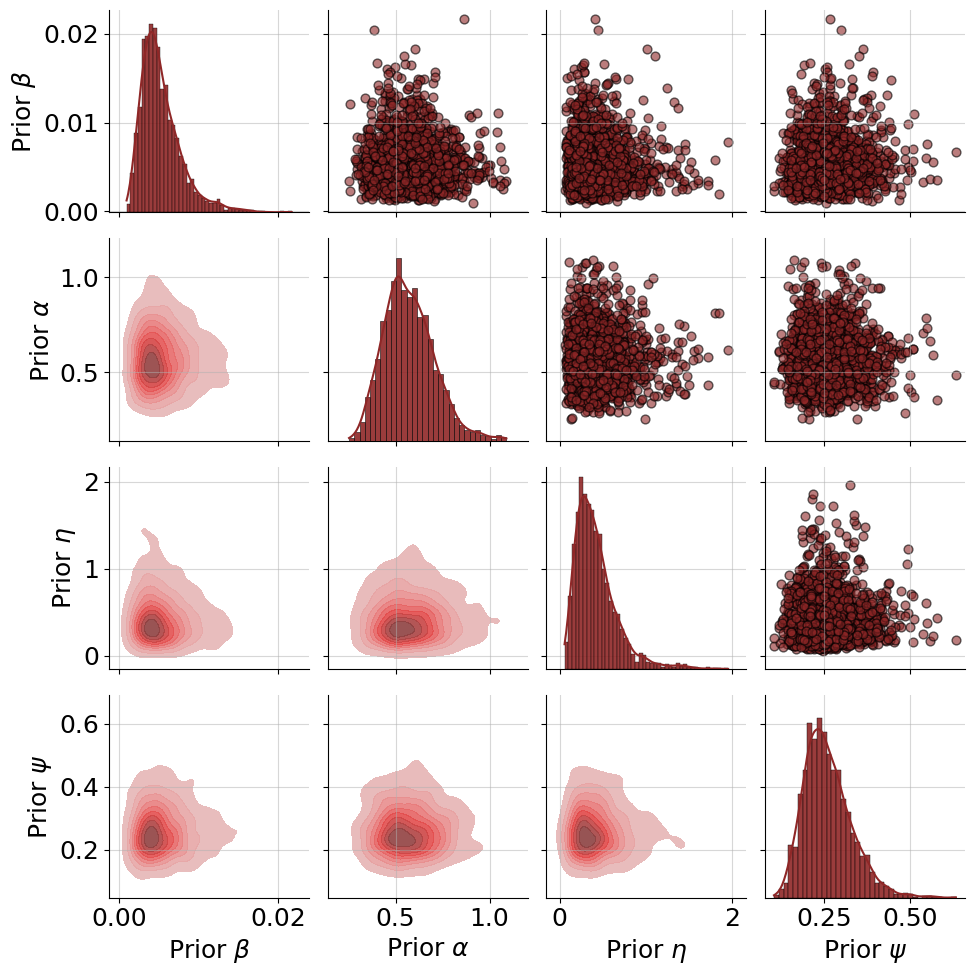

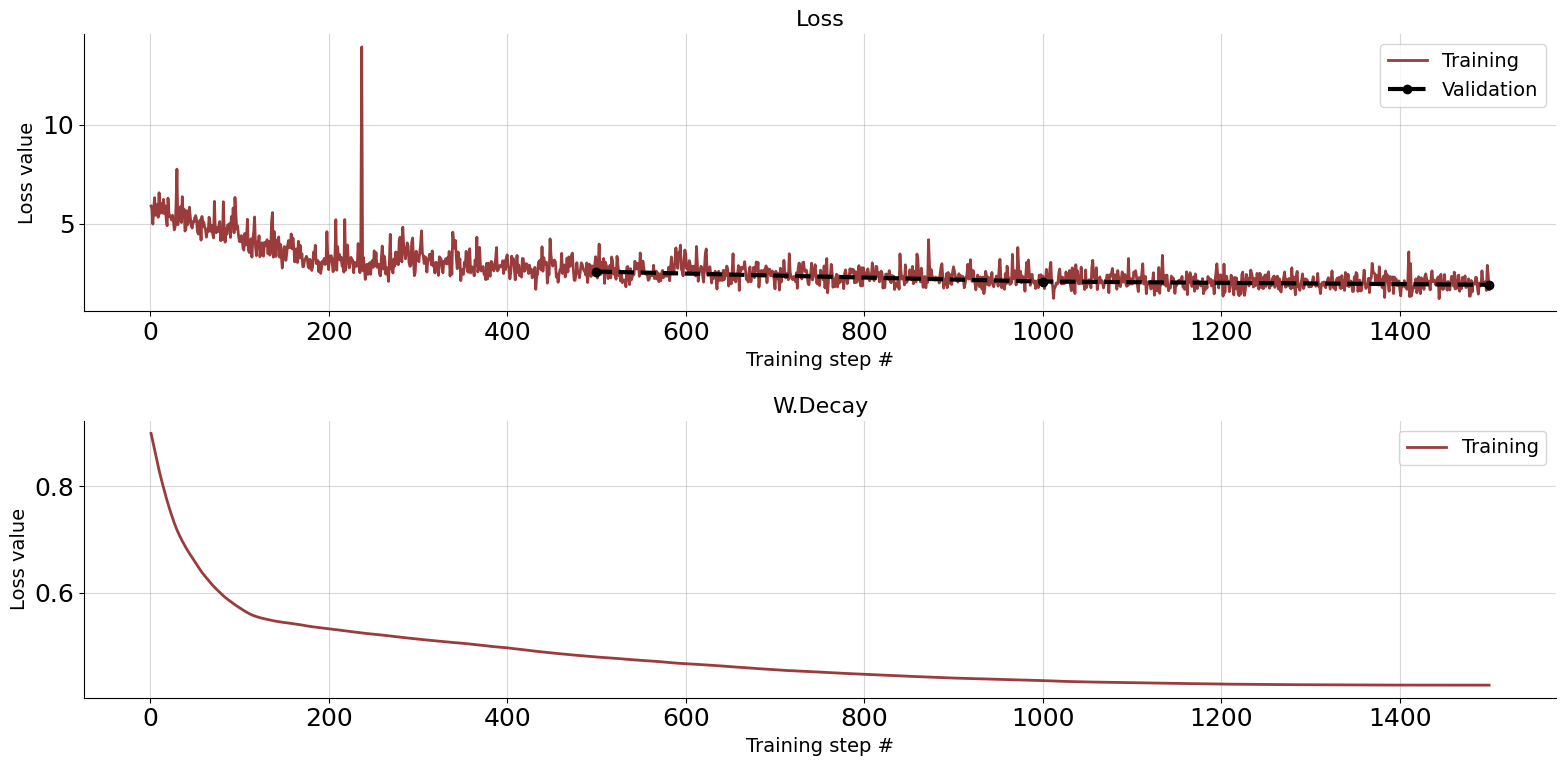

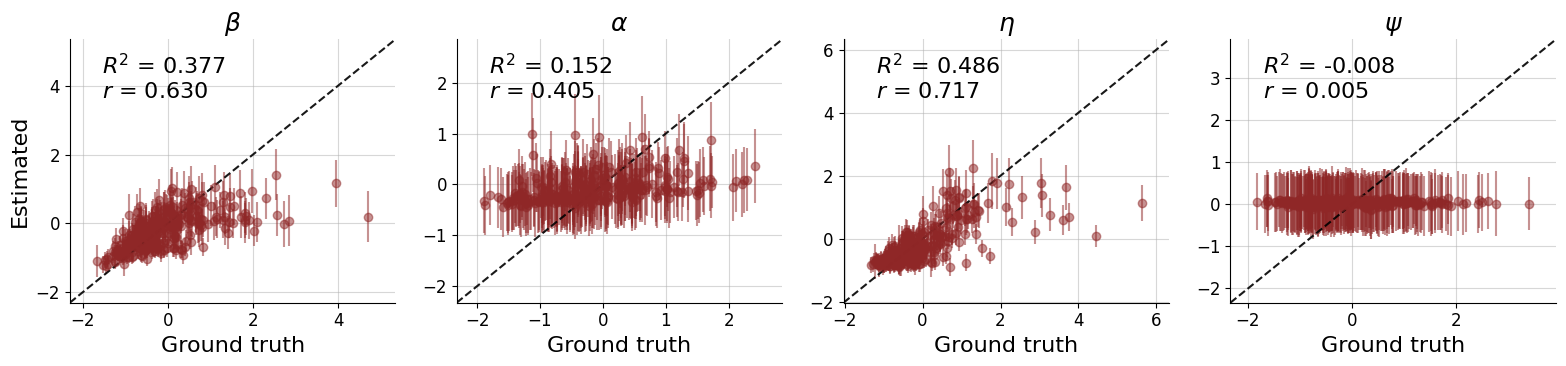

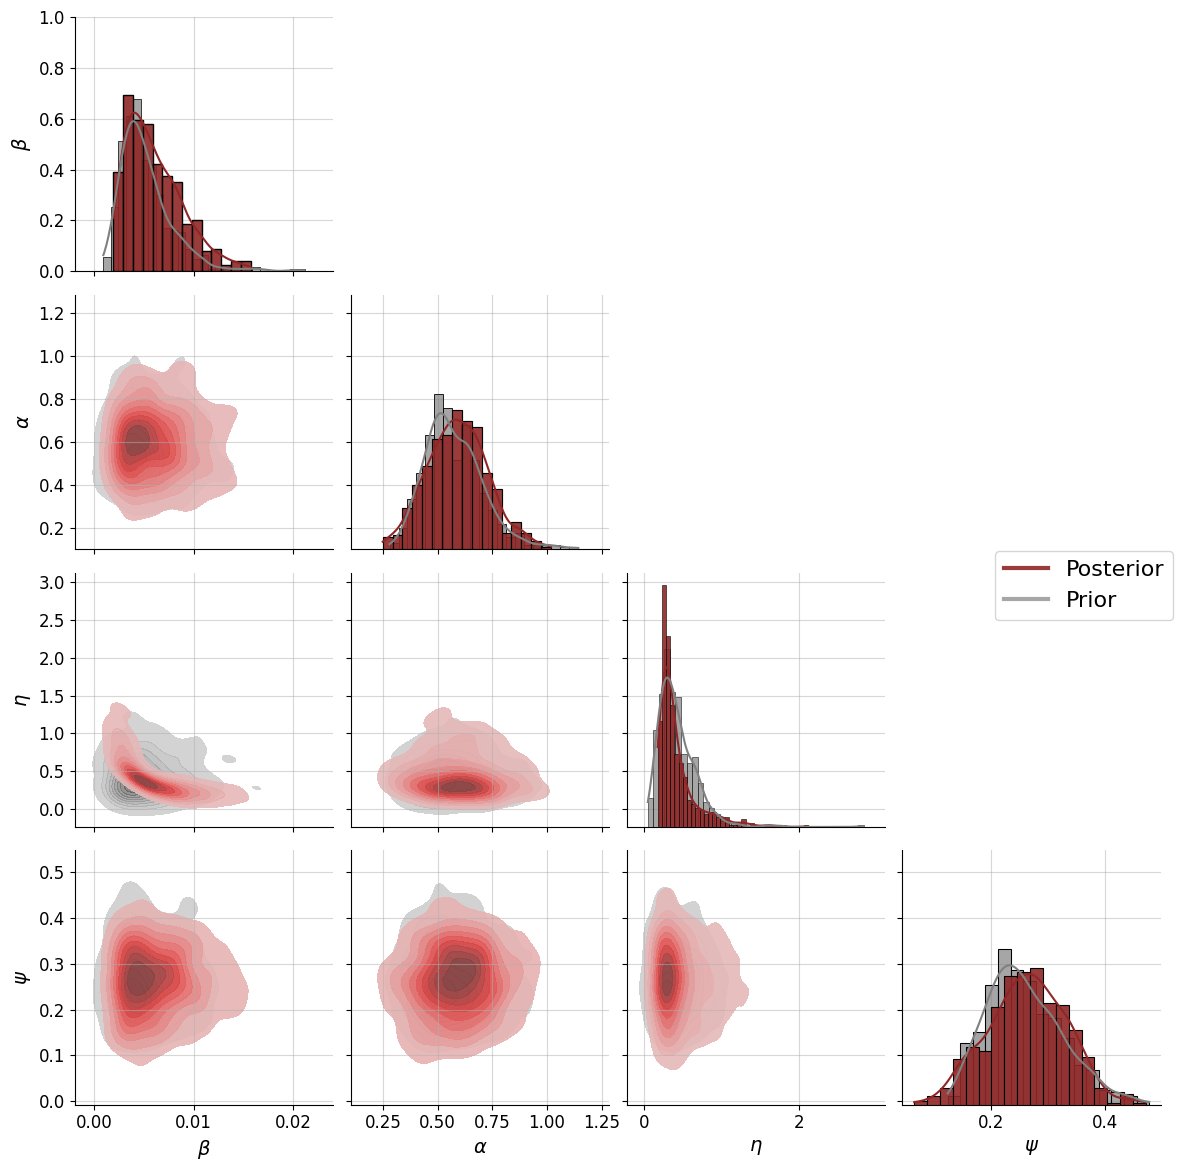

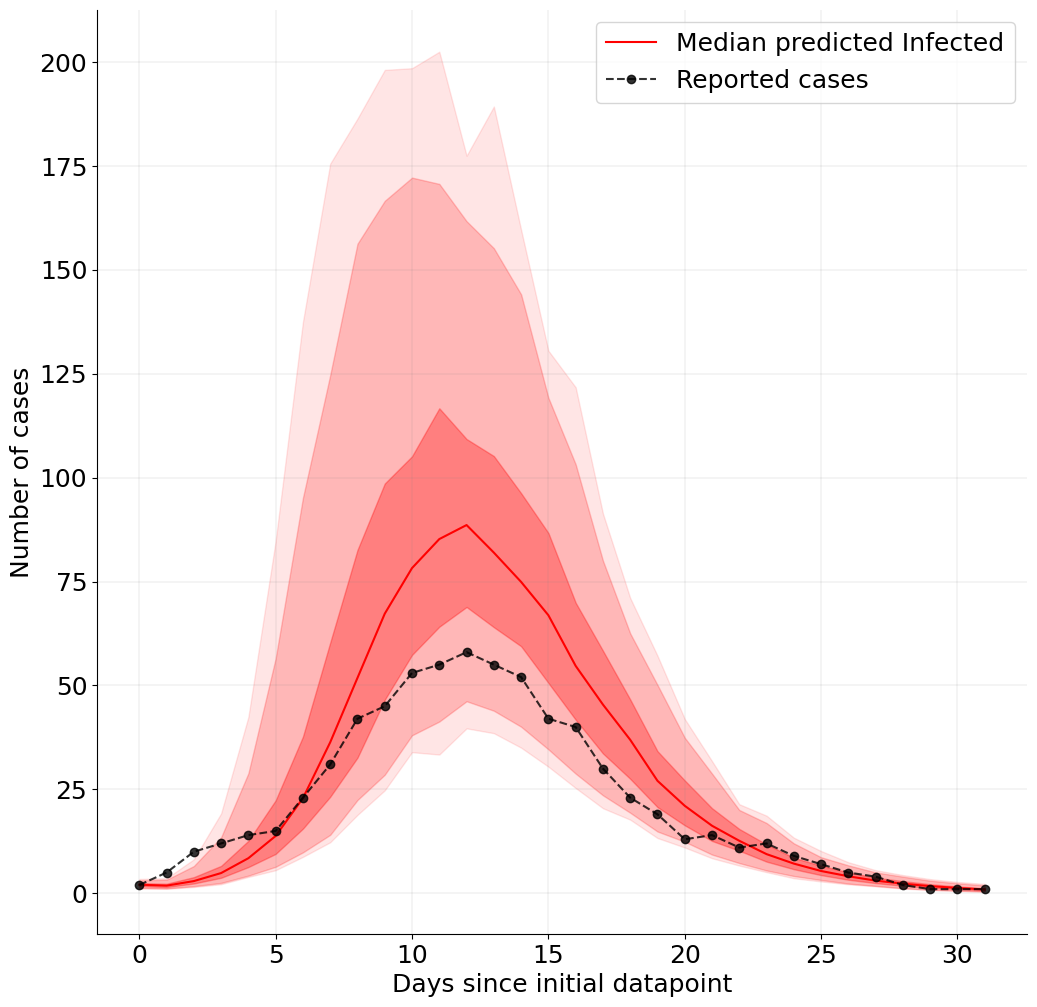

In [ ]:
loop = 1 #How many times do you want to recursively use the posterior as the prior?
while loop != 0:
  newParams = calcNextPriors()
  def model_prior2():
    """Generates random draws from the prior."""
    beta = RNG.lognormal(mean=newParams[0], sigma=newParams[1])
    alpha = RNG.lognormal(mean=newParams[2], sigma=newParams[3])
    eta = RNG.lognormal(mean=newParams[4], sigma=newParams[5])
    psi = RNG.lognormal(mean=newParams[6], sigma=newParams[7])
    return np.array([beta, alpha, eta, psi])

  prior = Prior(prior_fun=model_prior2, param_names=[r'$\beta$', r'$\alpha$', r'$\eta$', r'$\psi$'])

  prior_means, prior_stds = prior.estimate_means_and_stds()

  simulator = Simulator(
      simulator_fun=partial(stationary_SIR, T=config['T'], N=config['N'])
  )

  model = GenerativeModel(prior, simulator, name='basic_EBS_simulator')
  # As per default, the plot_prior2d function will obtain 1000 draws from the joint prior.
  f = prior.plot_prior2d()
  summary_net = SequentialNetwork()
  inference_net = InvertibleNetwork(num_params=len(prior.param_names), num_coupling_layers=3)
  amortizer = AmortizedPosterior(inference_net, summary_net, name='EBS_amortizer')
  # change var_obs
  trainer = Trainer(amortizer=amortizer, 
                  generative_model=model, 
                  configurator=configure_input)
  model(32);
  h = trainer.train_online(epochs=3, iterations_per_epoch=500, batch_size=32, validation_sims=200)
  f = diag.plot_losses(h['train_losses'], h['val_losses'])
  # Generate some validation data
  validation_sims = trainer.configurator(model(batch_size=300))

  # Generate posterior draws for all simulations
  post_samples = amortizer.sample(validation_sims, n_samples=100)
  post_samples = amortizer.sample(validation_sims, n_samples=500)
  f = diag.plot_recovery(post_samples, validation_sims['parameters'], param_names=prior.param_names)
  # Format data into a 3D array of shape (1, n_time_steps, 1) and perform log transform
  obs_data = np.log1p(config['obs_data'])[np.newaxis, :, np.newaxis].astype(np.float32)
  # Obtain 500 posterior draws given real data
  post_samples = amortizer.sample({'summary_conditions': obs_data}, 500)

  # Undo standardization to get parameters on their original (unstandardized) scales
  post_samples = prior_means + post_samples * prior_stds
  f = diag.plot_posterior_2d(post_samples, prior=prior)
  f = plot_ppc(config, post_samples)
  
  loop-=1